In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
import fsps
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from spec_exam import Gen_spec

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [203]:
def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)

def LOWESS(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

# check rolling SFH

In [4]:
from spec_stats import Leave_one_out
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    dt_bs = []
    w = Leave_one_out(np.array(sfh), lbt)
    wsfh = [w[U]*sfh[U] for U in range(len(sfh))]
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))            
        S= np.sum(np.array(wsfh)[IDX], axis=0)
#         S= np.sum(np.array(sfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)
        iT = interp1d(np.cumsum(istack[::-1]) / np.cumsum(istack[::-1])[-1], lbt - min(lbt))
        dt_bs.append(iT(0.9) - iT(0.5))
        
    sfh_bs = np.array(sfh_bs)
    dt_bs = np.array(dt_bs)
    
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    DT = np.percentile(dt_bs,50)
    DT16 = np.percentile(dt_bs,16)
    DT84 = np.percentile(dt_bs,84)
            
    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84, DT, DT16, DT84

In [116]:
S1db = mdb.sort_values('zgrism')


In [9]:
import pickle
from make_sfh_tool import Gen_SFH

idx = 0
LBT = np.linspace(0,14, 1000)
L=[]
S=[]
Sl=[]
Sh=[]
DT=[]
DTl=[]
DTh=[]

zg = []
M = []
while idx < len(S1db.index)-14:
    SFH_grid = []
    s1_grid = []
    M_grid = []
    for i in S1db.index[idx:idx + 15]:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
            
        except:
            try:
                with open('../data/SFH/{}_{}.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH 
                
            except:
                with open('../data/SFH/{}_{}_1D.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH                
                
        isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
        SFH_grid.append(isfh)
        s1_grid.append(S1db.zgrism[i])
        M_grid.append(10**S1db.lmass[i])
    
    L1,S1,S16,S84,dt, dt16, dt84  = Sum_SFH_bs(LBT, SFH_grid)
    L.append(L1)
    S.append(S1)
    Sl.append(S16)
    Sh.append(S84)
    DT.append(dt)
    DTl.append(dt16)
    DTh.append(dt84)
    
    zg.append(np.mean(s1_grid))
    M.append(np.mean(M_grid))
    
    idx+=1

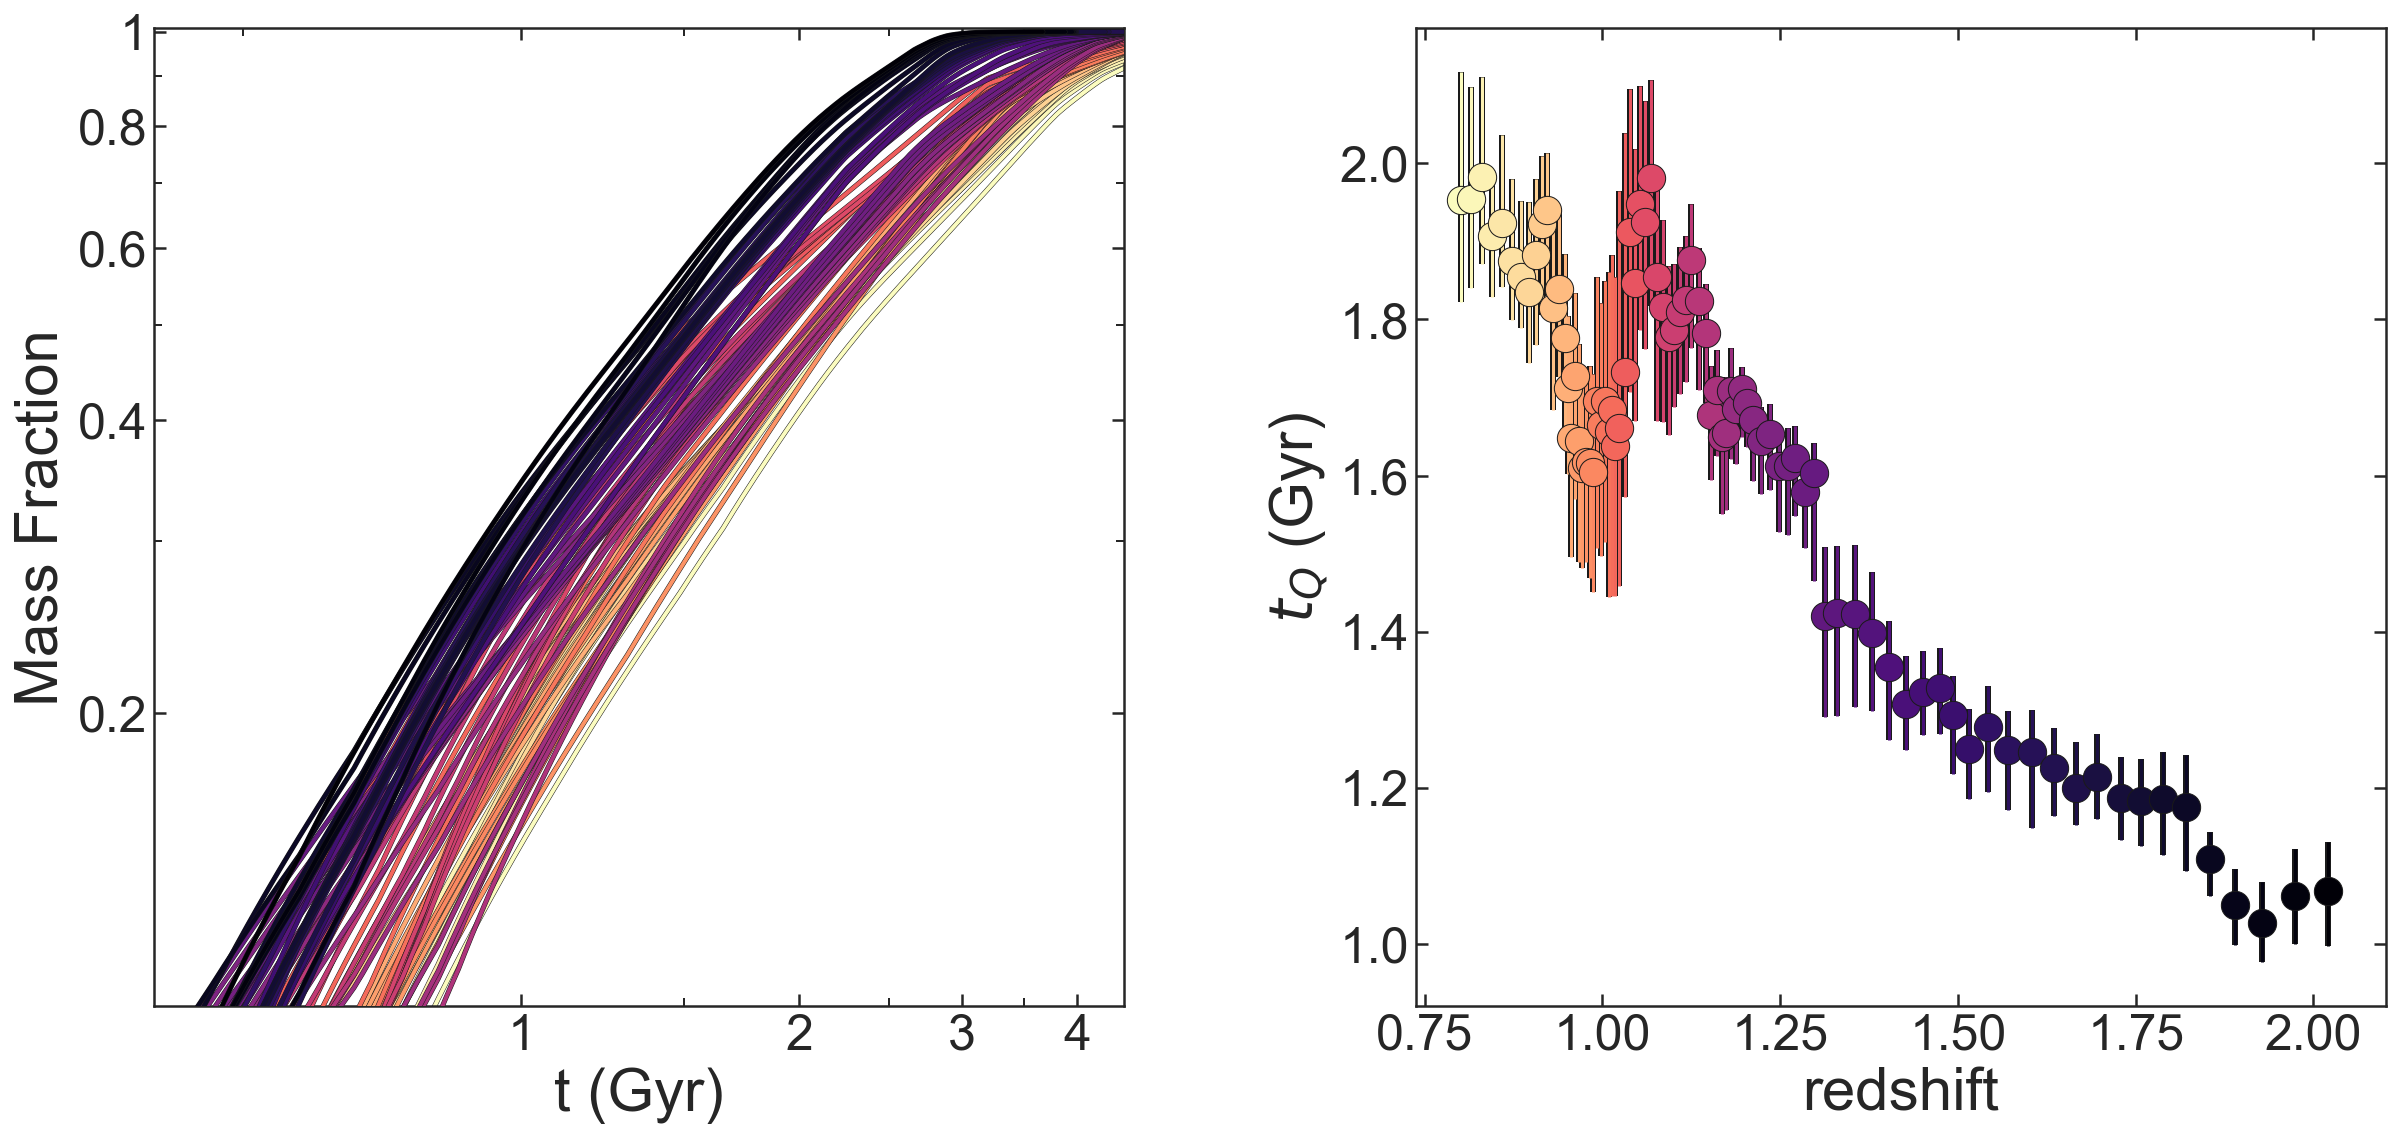

In [14]:
from matplotlib import cm
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=len(L))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

gs = gridspec.GridSpec(1,2, wspace=0.3)

plt.figure(figsize =[20,9])
ax2 = plt.subplot(gs[0])
ax3 = plt.subplot(gs[1])

######## C SFH
idx = 0
for i in range(len(L)):
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
             linewidth = 2, zorder = idx + 1)
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1
ax2.set_ylabel('Mass Fraction', fontsize=30)
ax2.set_xlabel('t (Gyr)', fontsize=30)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.4,4.5)
ax2.set_ylim(0.1,1.01)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels([1,2,3,4])
ax2.set_xticks([0.5,1.5,2.5,3.5], minor=True)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0.3,0.5,0.7,0.9], minor=True)

ax2.tick_params(axis='both', which='major', labelsize=25)

########## delta t    
dt = []
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    ax3.errorbar(zg[i],iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
                color = 'k', zorder =1, elinewidth = 3)
    ax3.errorbar(zg[i],iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
                color =  np.array(cm.magma_r(norm(i),bytes=True))/255, zorder =2)
    ax3.scatter(zg[i],iT(0.9)-iT(0.5),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
                edgecolors='k', linewidths=0.5,s = 200, zorder =3 )

ax3.set_ylabel('$t_Q$ (Gyr)', fontsize=30)
ax3.set_xlabel('redshift', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=25)
sz= 3.2


(0, 6)

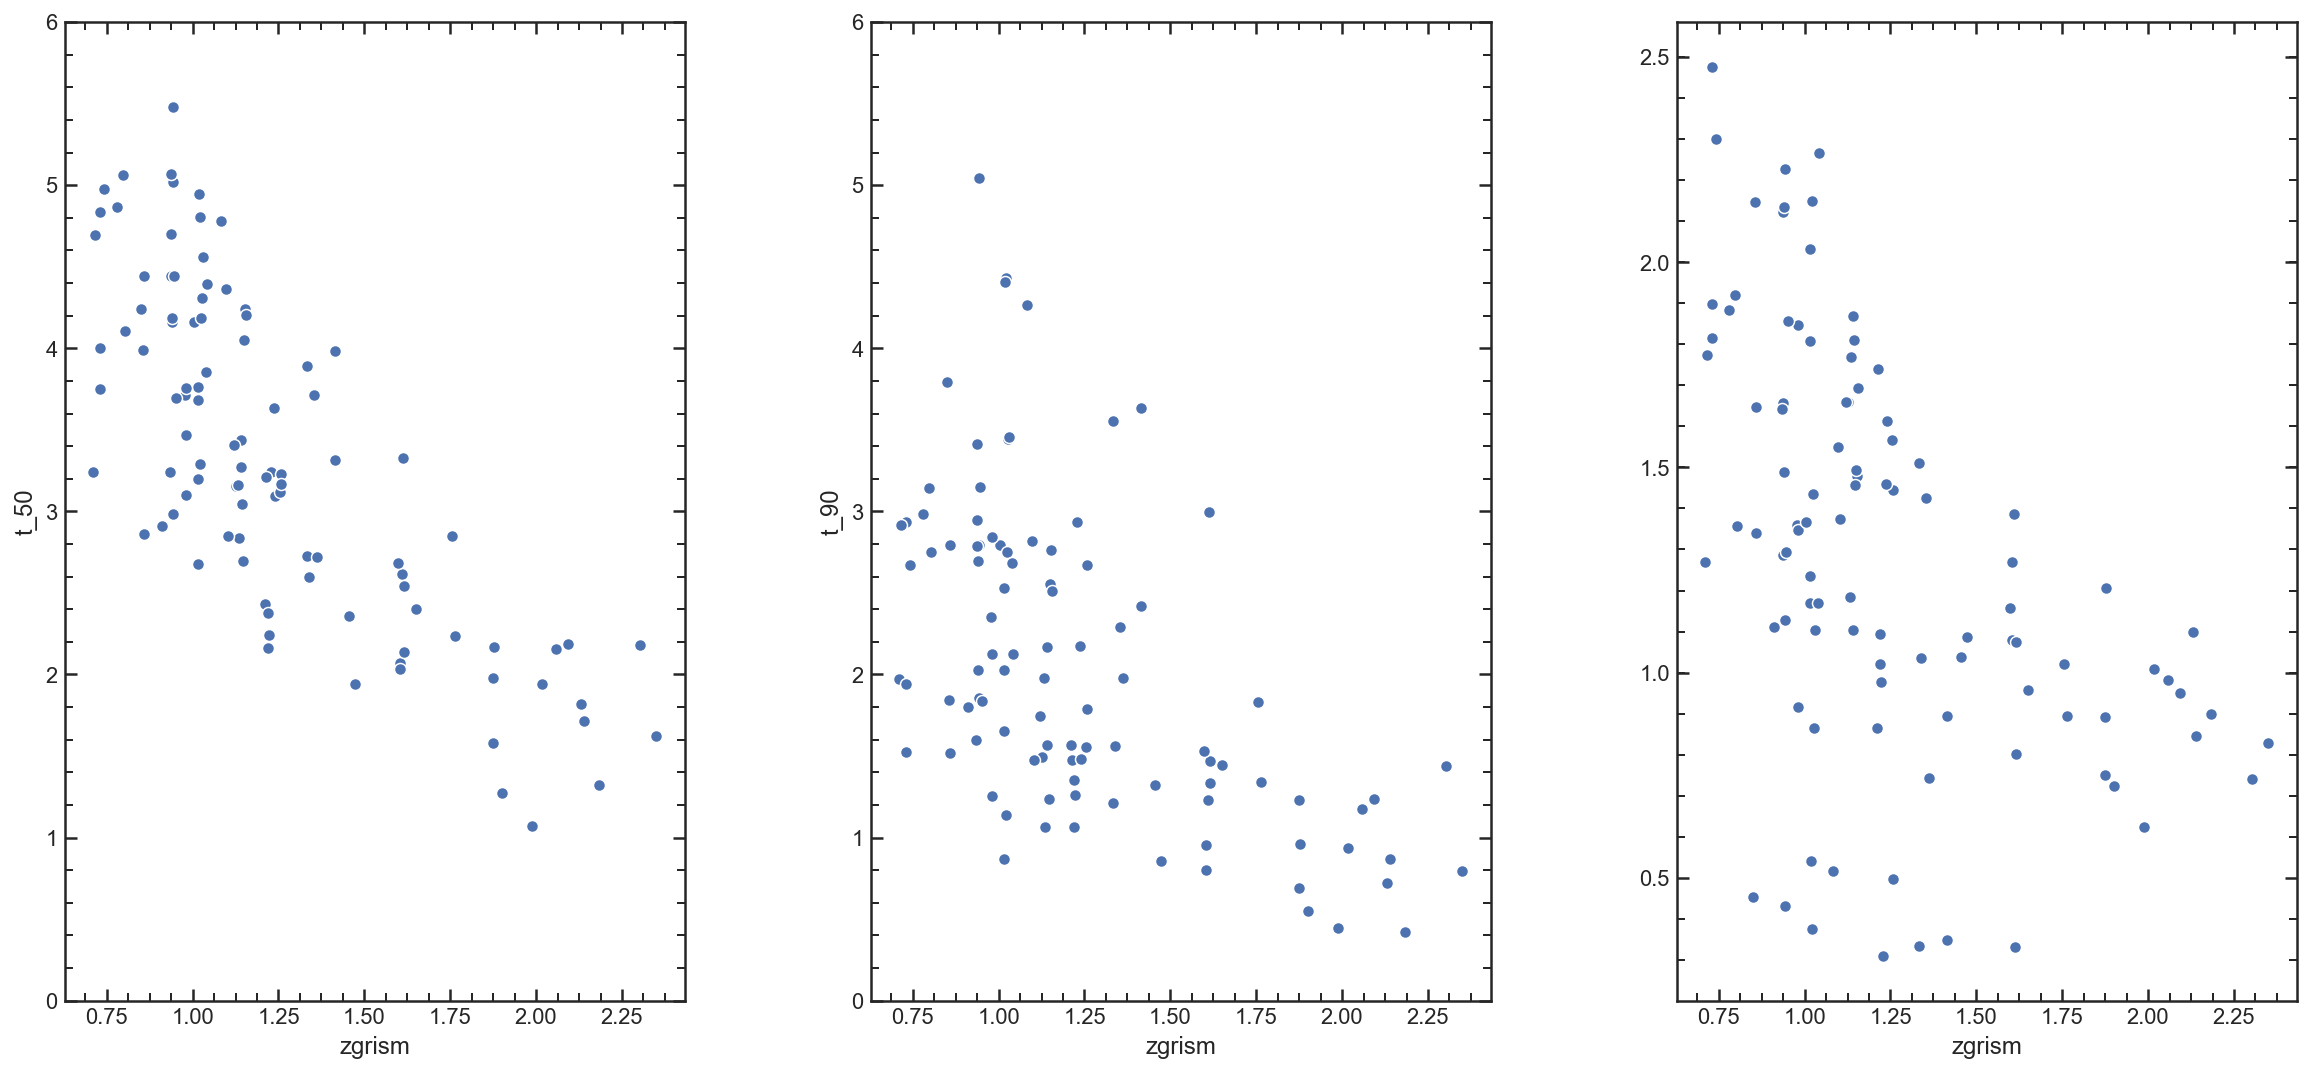

In [3]:
gs = gridspec.GridSpec(1,3, wspace=0.3)

plt.figure(figsize =[20,9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

sea.scatterplot(mdb.zgrism, mdb.t_50, ax = ax1)
sea.scatterplot(mdb.zgrism, mdb.t_90, ax = ax2)
sea.scatterplot(mdb.zgrism, mdb.t_50 - mdb.t_90, ax = ax3)

ax1.set_ylim(0,6)
ax2.set_ylim(0,6)

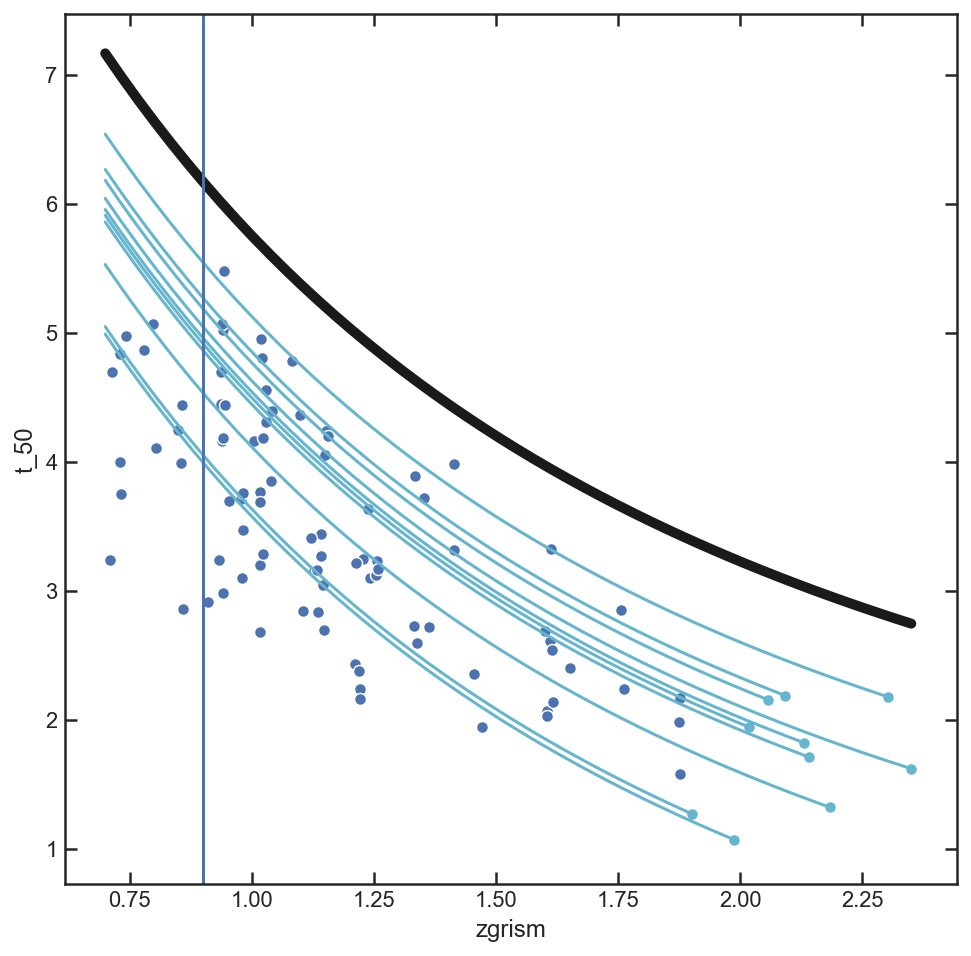

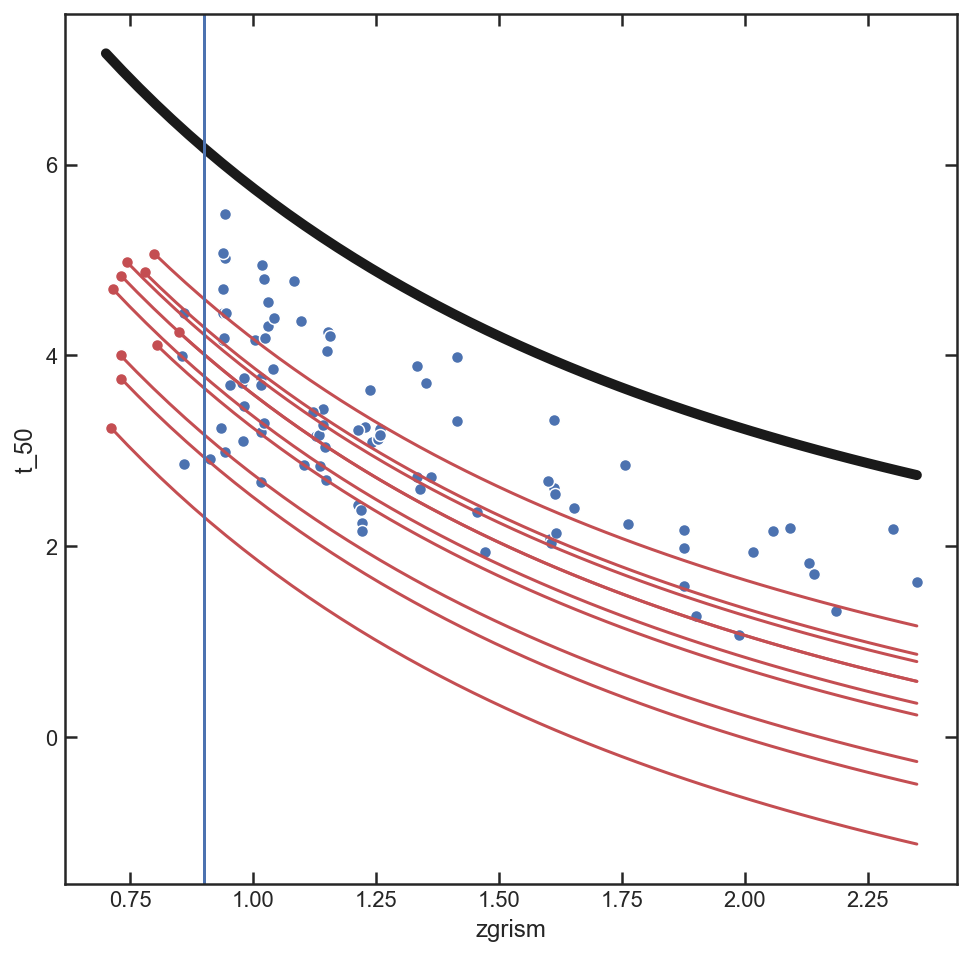

In [68]:
plt.figure(figsize =[8,8])

sea.scatterplot(mdb.zgrism, mdb.t_50)

for i in S1db.index[-10:]:  
    z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
    a_init = cosmo.age(z_init).value
    zs = np.linspace(0.7, z_init)
    a = cosmo.age(zs).value
    a -= a_init
    sea.scatterplot(mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism, 
                    mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50, color = 'c')
    plt.plot(zs, mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a, color = 'c')
plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

plt.axvline(0.9)
    
    
plt.figure(figsize =[8,8])

sea.scatterplot(mdb.zgrism, mdb.t_50)
for i in S1db.index[:10]:
    z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
    a_init = cosmo.age(z_init).value
    zs = np.linspace(z_init, 2.35)
    a = cosmo.age(zs).value
    a -= a_init
    sea.scatterplot(mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism, 
                    mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50, color = 'r')
    plt.plot(zs, mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a, color = 'r')

    
plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

plt.axvline(0.9)

(0, 4)

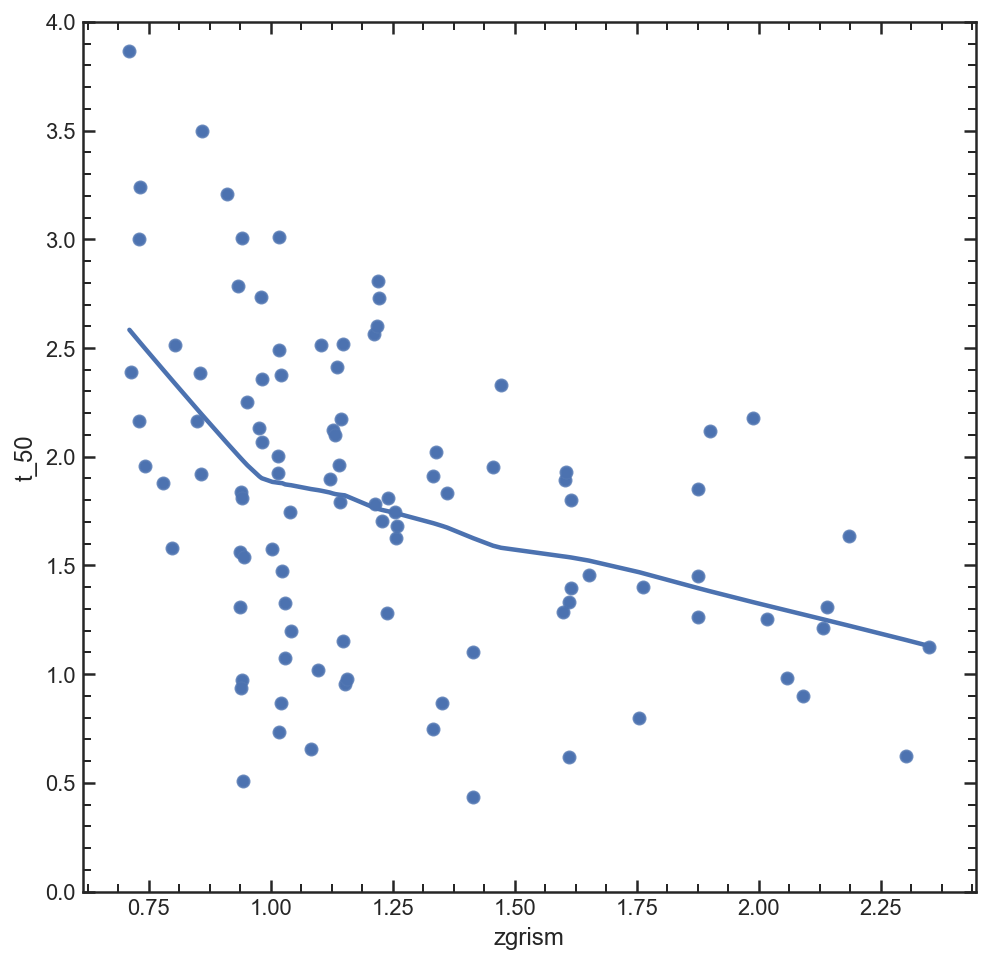

In [18]:
plt.figure(figsize =[8,8])

iage = interp1d(np.linspace(0.6,2.5), cosmo.age(np.linspace(0.6,2.5)))

sea.scatterplot(mdb.zgrism, iage(mdb.zgrism) - mdb.t_50)
sea.regplot(mdb.zgrism, iage(mdb.zgrism) - mdb.t_50, lowess=True)
plt.ylim(0,4)
# plt.axvline(0.9)

young 37186 10.046496895590227
old 22358 9.767971939198802
old 23459 10.006211639767342
young 32108 9.718439085169818
old 36838 9.939367297801896
young 41147 9.95965190438213
old 13774 10.137551878955287
old 47140 9.709204660042753
old 27006 10.13310760652903
young 29879 9.986786806160207
young 24795 9.730218449315137
young 46001 10.049206634793112
young 21683 10.207751461622989


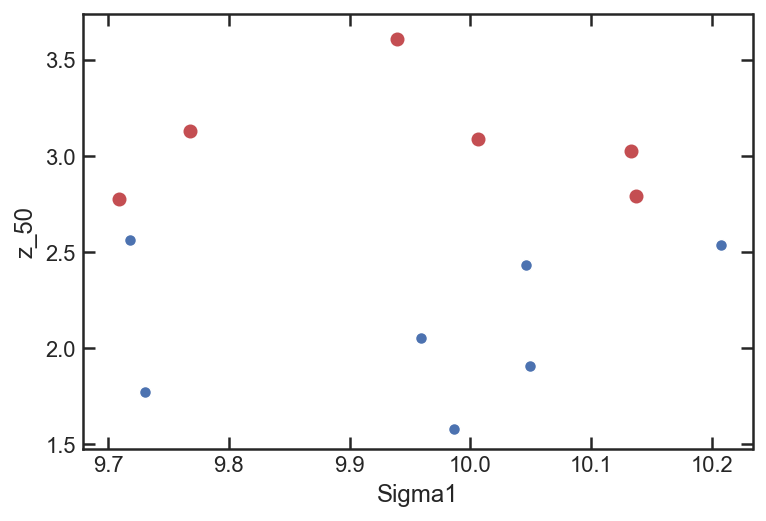

In [243]:
z_init = mdb.query('1.98 < zgrism < 2.01 ').zgrism.values[0]
a_init = cosmo.age(z_init).value
zs = np.linspace(0.7, z_init)
a = cosmo.age(zs).value
a -= a_init

ilim = interp1d(zs, mdb.query('1.98 < zgrism < 2.01 ').t_50.values[0] + a)


sea.scatterplot(np.log10(mdb.query('zgrism < 0.9').Sigma1), mdb.query('zgrism < 0.9').z_50)

for i in mdb.query('zgrism < 0.9').index:
    if mdb.t_50[i] >= ilim(mdb.zgrism[i]):
        plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = 'r')
        print('old ' + str(mdb.id[i]), np.log10(mdb.Sigma1[i]))
    else:
        print('young ' + str(mdb.id[i]), np.log10(mdb.Sigma1[i]))
        

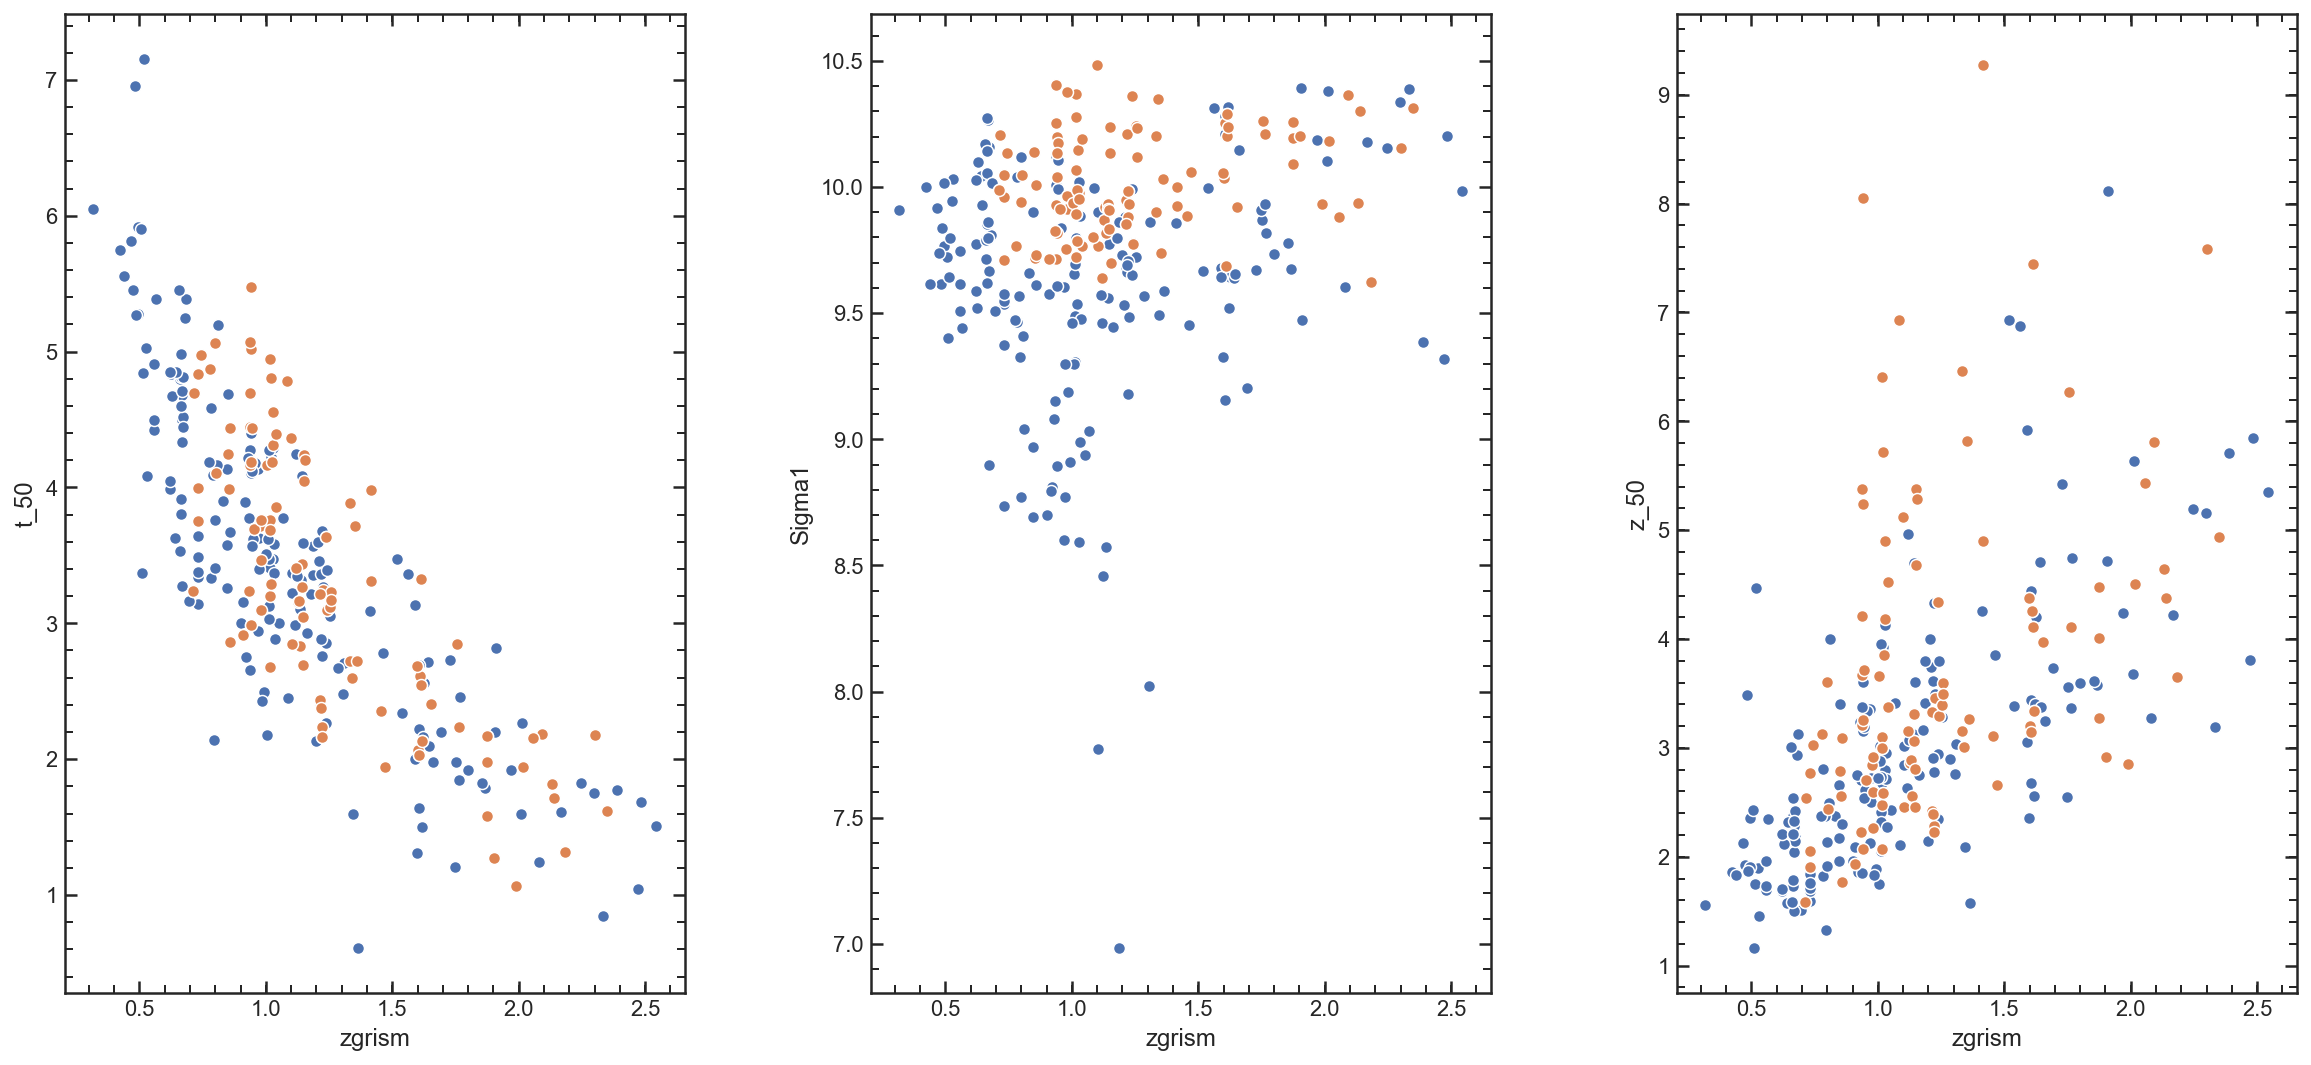

In [31]:
gs = gridspec.GridSpec(1,3, wspace=0.3)

plt.figure(figsize =[20,9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

sea.scatterplot(alldb.query('zgrism >0 and t_50 > 0').zgrism, alldb.query('zgrism >0 and t_50 > 0').t_50, ax = ax1)
sea.scatterplot(mdb.zgrism, mdb.t_50, ax = ax1)

sea.scatterplot(alldb.query('zgrism >0 and t_50 > 0').zgrism, np.log10(alldb.query('zgrism >0 and t_50 > 0').Sigma1), ax = ax2)
sea.scatterplot(mdb.zgrism, np.log10(mdb.Sigma1), ax = ax2)

sea.scatterplot(alldb.query('zgrism >0 and t_50 > 0').zgrism, alldb.query('zgrism >0 and t_50 > 0').z_50, ax = ax3)
sea.scatterplot(mdb.zgrism, mdb.z_50, ax = ax3)


In [116]:
import pickle
from make_sfh_tool import Gen_SFH

field = 'GND'
gid = 23018

try:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, gid))

except:
    try:
        with open('../data/SFH/{}_{}.pkl'.format(field, gid), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH 

    except:
        with open('../data/SFH/{}_{}_1D.pkl'.format(field, gid), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH                

lbt2 = lbt
sfh2 = sfh

235    2.301924
Name: zgrism, dtype: float64
3.8331283450464637 Gyr


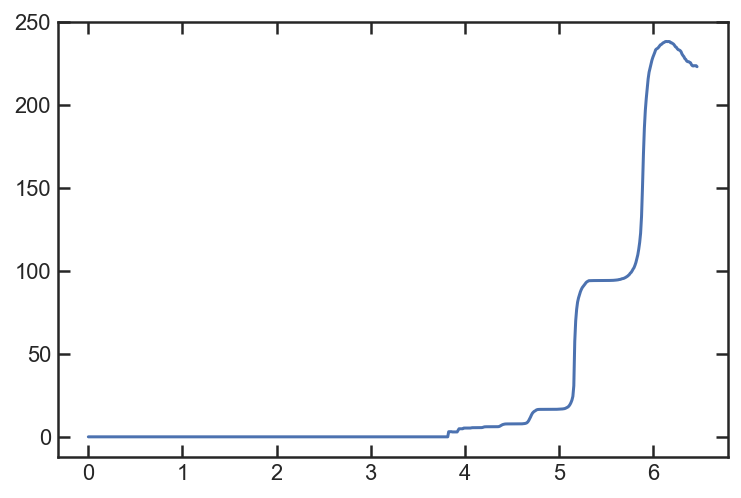

In [168]:
print(mdb.query('id == 23018').zgrism)
print(cosmo.age(0.8) - cosmo.age(2.3))
plt.plot(np.append(np.arange(0,3.83,0.01) ,3.83 + lbt2), np.append(np.zeros(len(np.arange(0,3.83,0.01) )),sfh2))

In [169]:
lbtN = np.append(np.arange(0,3.83,0.01) ,3.83 + lbt2)
sfhN = np.append(np.zeros(len(np.arange(0,3.83,0.01))),sfh2)

In [136]:
M=[]
for i in range(len(lbt2)):
    mass = np.trapz(sfh2[0:i+1],lbt2[0:i+1])
    M.append(mass)

t_50= interp1d(M/ M[-1], lbt2)(0.5)


MN=[]
for i in range(len(lbtN)):
    mass = np.trapz(sfhN[0:i+1],lbtN[0:i+1])
    MN.append(mass)

t_50N = interp1d(MN/ MN[-1], lbtN)(0.5)

In [293]:
np.save('../data/SFH/sim_sfh', [lbtN, sfhN])

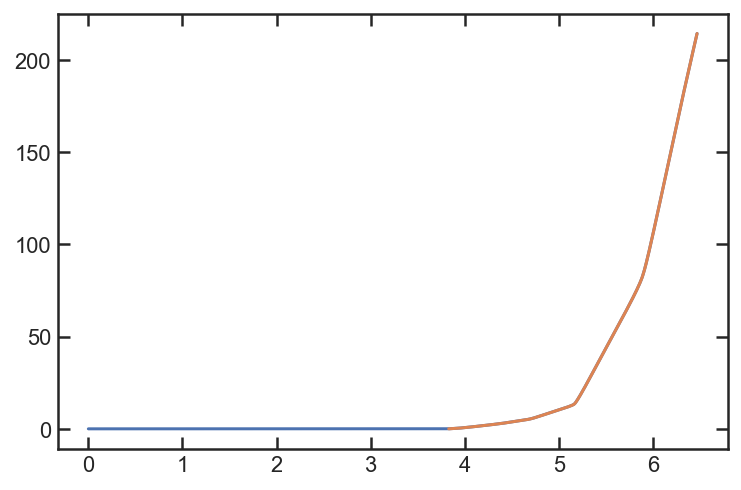

In [142]:
plt.plot(lbtN, MN)
plt.plot(lbt2 + 3.83, M)

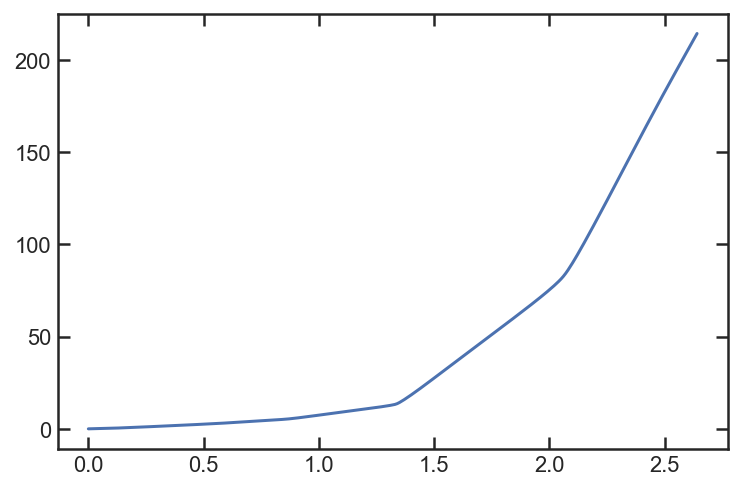

In [138]:
plt.plot(lbt2, M)

In [141]:
t_50, t_50N, 3.83 + t_50

(array(2.17818462), array(6.0081509), 6.00818462046315)

In [155]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

In [180]:
sp.set_tabular_sfh(lbtN,sfhN[::-1]) 
wave1, flux1 = sp.get_spectrum(tage = max(lbt2), peraa = True)
wave2, flux2 = sp.get_spectrum(tage = max(lbt2) + 3.83, peraa = True)

(1000, 8000)

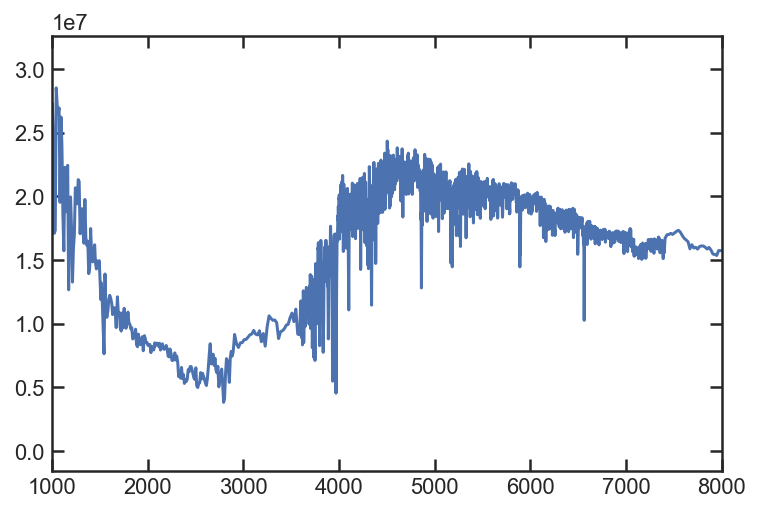

In [181]:
plt.plot(wave1,flux1)
plt.xlim(1000,8000)

(1000, 8000)

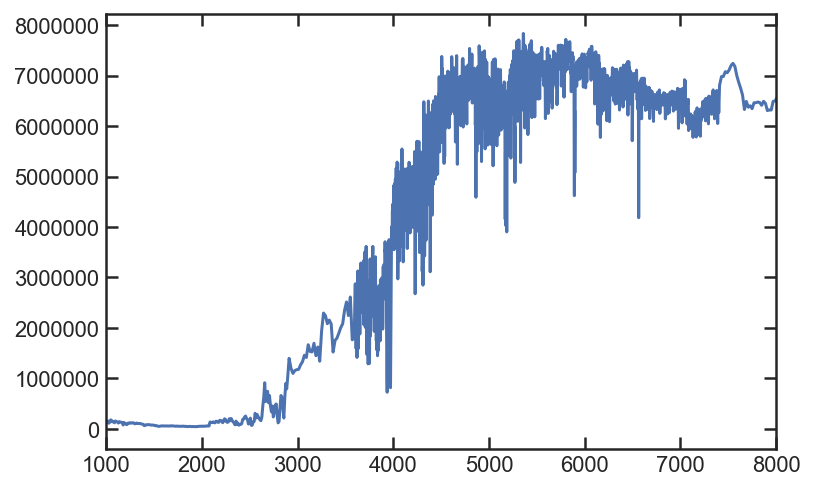

In [182]:
plt.plot(wave2,flux2)
plt.xlim(1000,8000)

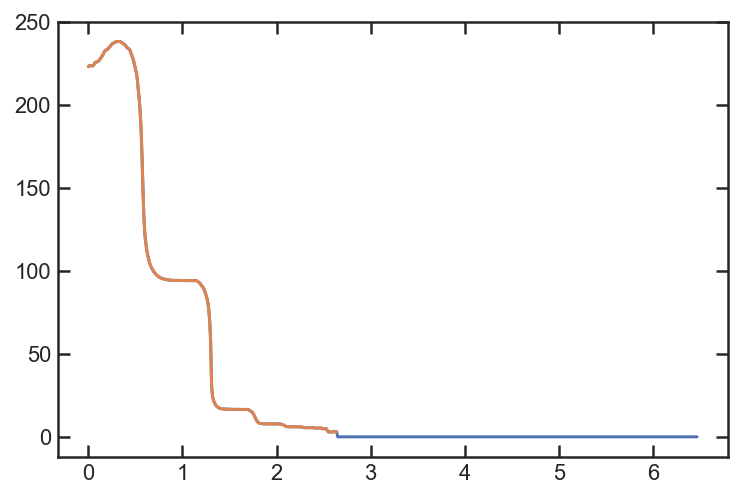

In [170]:
plt.plot(lbtN, sfhN[::-1])
plt.plot(lbt2, sfh2[::-1])

In [174]:
sp.sfr

array([2.23054403e+02, 2.23056691e+02, 2.23059259e+02, 2.23062139e+02,
       2.23065372e+02, 2.23068998e+02, 2.23073067e+02, 2.23077632e+02,
       2.23082755e+02, 2.23088503e+02, 2.23094952e+02, 2.23102187e+02,
       2.23110306e+02, 2.23119415e+02, 2.23129636e+02, 2.23141104e+02,
       2.23153972e+02, 2.23168409e+02, 2.23184608e+02, 2.23202783e+02,
       2.23223177e+02, 2.23246058e+02, 2.23271732e+02, 2.23300538e+02,
       2.23332859e+02, 2.23369124e+02, 2.23409814e+02, 2.23455469e+02,
       2.23506695e+02, 2.23564171e+02, 2.23628660e+02, 2.23629961e+02,
       2.23631421e+02, 2.23633058e+02, 2.23634896e+02, 2.23636957e+02,
       2.23639270e+02, 2.23636776e+02, 2.23633864e+02, 2.23630596e+02,
       2.23603022e+02, 2.23542060e+02, 2.23473659e+02, 2.23544425e+02,
       2.23636879e+02, 2.24060234e+02, 2.24669899e+02, 2.25469272e+02,
       2.25698604e+02, 2.26029332e+02, 2.26059598e+02, 2.26672477e+02,
       2.27718010e+02, 2.29153733e+02, 2.30527995e+02, 2.32604296e+02,
      

In [273]:
Gs = Gen_spec('GND', 23459, 0.8, decontam=False, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icat26dtq_flt.fits G102
2 icat26dyq_flt.fits G102
3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt61gvq_flt.fits G102
14 icxt61gwq_flt.fits G102
15 icxt61gzq_flt.fits G102
16 icxt61h1q_flt.fits G102
17 icxt64qrq_flt.fits G102
18 icxt64qsq_flt.fits G102
19 icxt64qvq_flt.fits G102
20 icxt64qxq_flt.fits G102
21 icxt65evq_flt.fits G102
22 icxt65ewq_flt.fits G102
23 icxt65ezq_flt.fits G102
24 icxt65f1q_flt.fits G102
25 ib3726bpq_flt.fits G141
26 ib3726btq_flt.fits G141
27 ib3726c5q_flt.fits G141
28 ib3726c9q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icat26dtq_flt.fits G102
2 icat26dyq_flt.fits G102
3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt61gvq_flt.fits G102
14 icxt61gwq_flt.fits G102
15 icxt61gzq_flt.fits G102
16 icxt61h1q_flt.fits G102
17 icxt64qrq_flt.fits G102
18 icxt64qsq_flt.fits G102
19 icxt64qvq_flt.fits G102
20 icxt64qxq_flt.fits G102
21 icxt65evq_flt.fits G102
22 icxt65ewq_flt.fits G102
23 icxt65ezq_flt.fits G102
24 icxt65f1q_flt.fits G102
25 ib3726bpq_flt.fits G141
26 ib3726btq_flt.fits G141
27 ib3726c5q_flt.fits G141
28 ib3726c9q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

In [287]:
# Gs.Sim_all_premade(wave2*(1.8),flux2)
Gs.Make_sim(wave2,flux2,specz=0.8, rndstate=100)

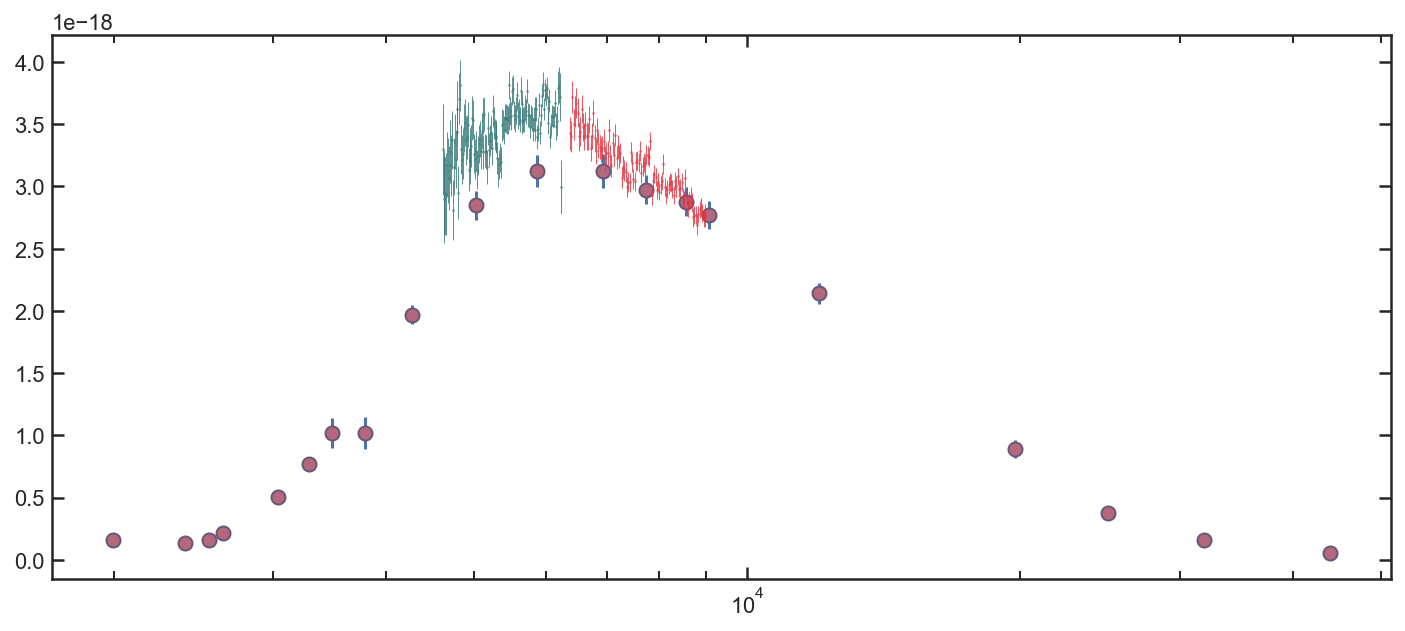

In [275]:
plt.figure(figsize=[12,5])
ax = plt.subplot()

ax.errorbar(Gs.Bwv_rf,Gs.Bfl,Gs.Ber,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

ax.errorbar(Gs.Rwv_rf,Gs.Rfl,Gs.Rer,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)


ax.errorbar(Gs.Pwv_rf,Gs.Pflx,Gs.Perr,
    linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
         markeredgecolor = '#685877',markeredgewidth = 1)
ax.set_xscale('log')

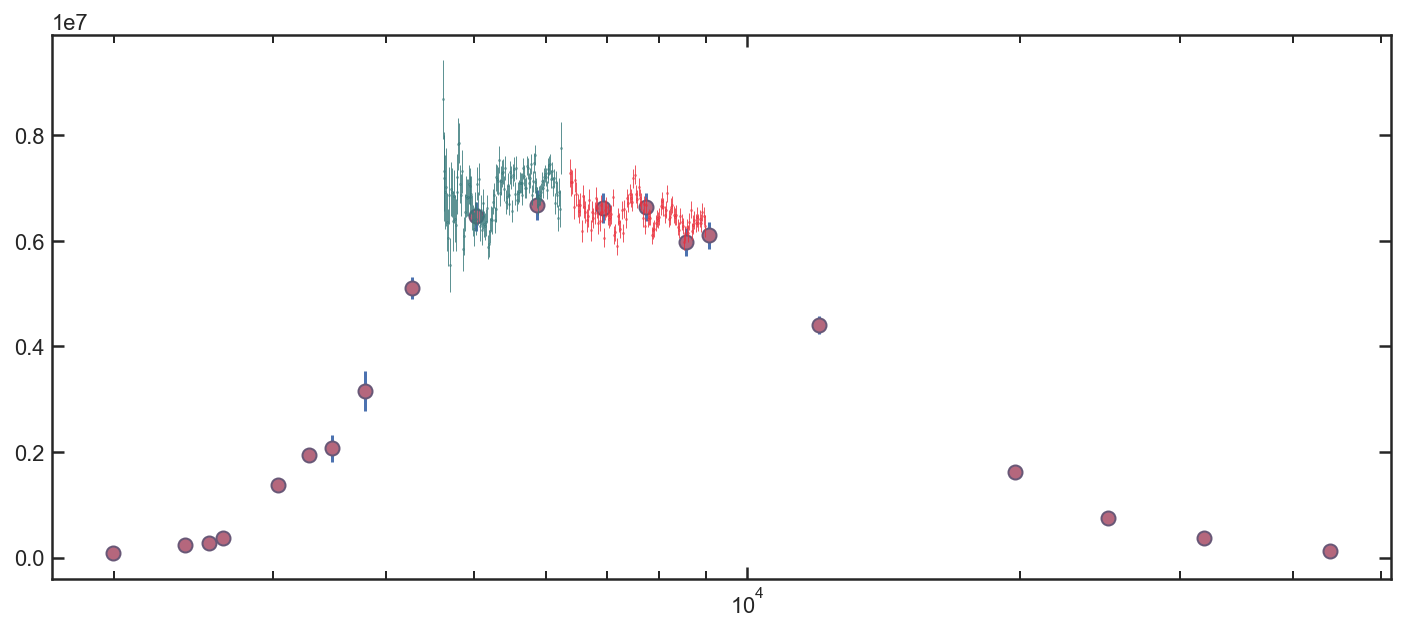

In [288]:
plt.figure(figsize=[12,5])
ax = plt.subplot()

ax.errorbar(Gs.Bwv_rf,Gs.SBfl,Gs.SBer,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

ax.errorbar(Gs.Rwv_rf,Gs.SRfl,Gs.SRer,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)


ax.errorbar(Gs.Pwv_rf,Gs.SPflx,Gs.SPerr,
    linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
         markeredgecolor = '#685877',markeredgewidth = 1)
ax.set_xscale('log')


<ErrorbarContainer object of 3 artists>

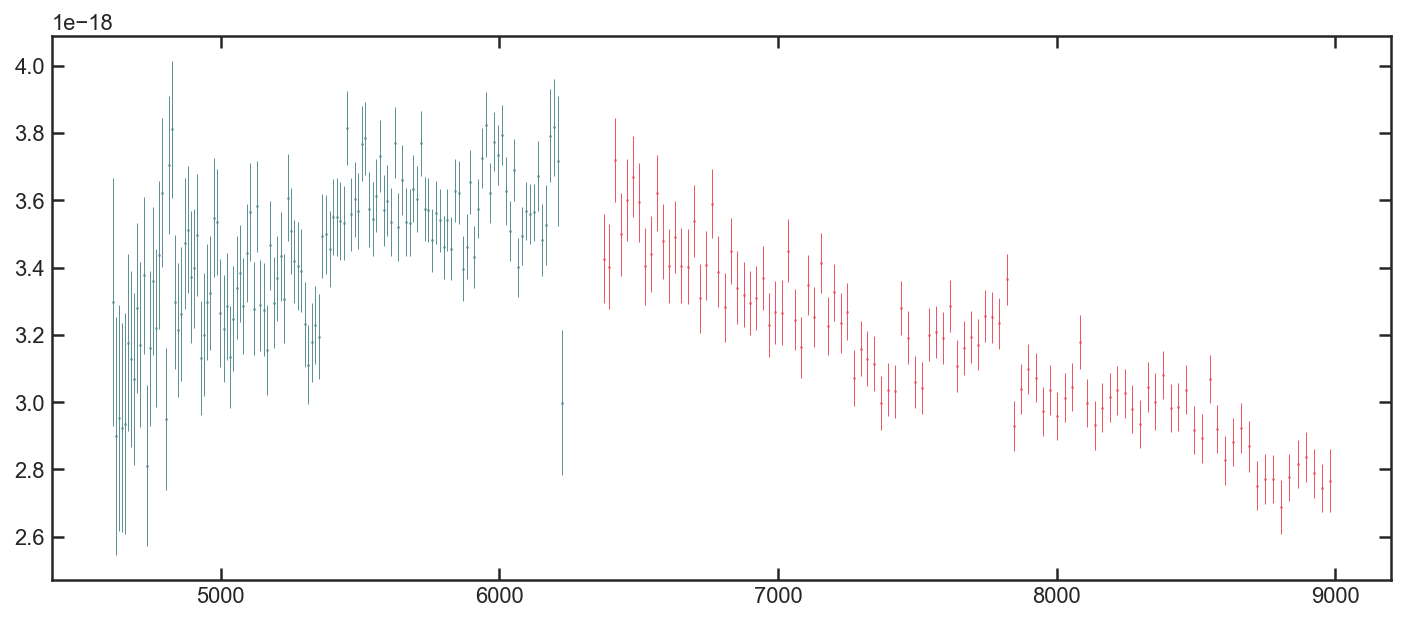

In [289]:
plt.figure(figsize=[12,5])
ax = plt.subplot()
ax.errorbar(Gs.Bwv_rf,Gs.Bfl,Gs.Ber,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

ax.errorbar(Gs.Rwv_rf,Gs.Rfl,Gs.Rer,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)

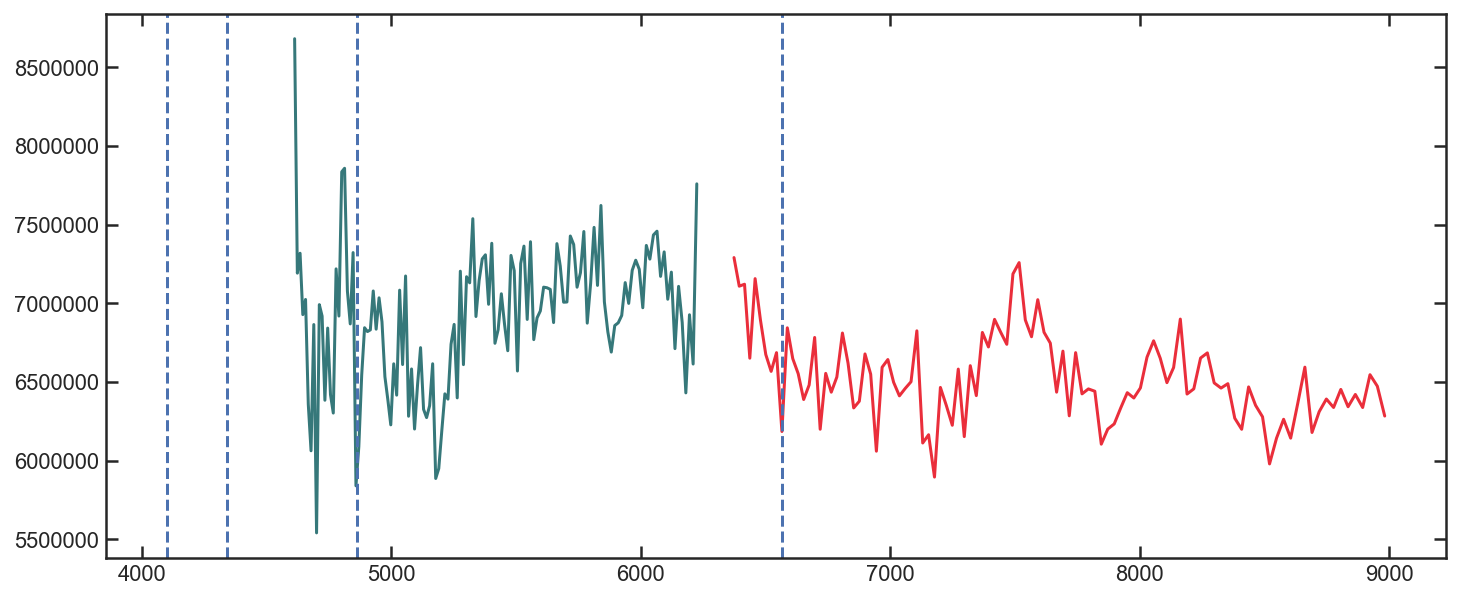

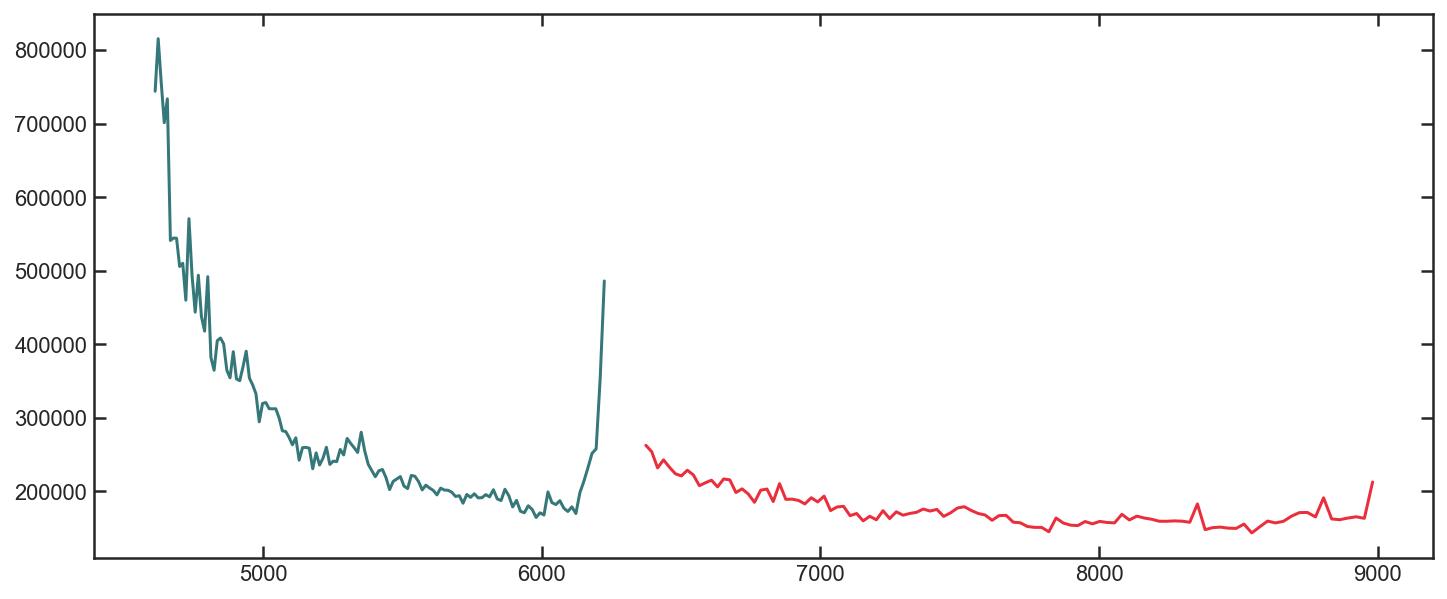

In [290]:
plt.figure(figsize=[12,5])
ax = plt.subplot()
ax.plot(Gs.Bwv_rf,Gs.SBfl, color='#36787A', zorder = 2)
ax.plot(Gs.Rwv_rf,Gs.SRfl, color='#EA2E3B', zorder = 2)

plt.axvline(4102.89 ,linestyle='--', color = 'b')
plt.axvline(4341.68 ,linestyle='--', color = 'b')
plt.axvline(4862.68 ,linestyle='--', color = 'b')
plt.axvline(6564.61,linestyle='--', color = 'b')

plt.figure(figsize=[12,5])
ax = plt.subplot()
ax.plot(Gs.Bwv_rf,Gs.SBer, color='#36787A', zorder = 2)
ax.plot(Gs.Rwv_rf,Gs.SRer, color='#EA2E3B', zorder = 2)


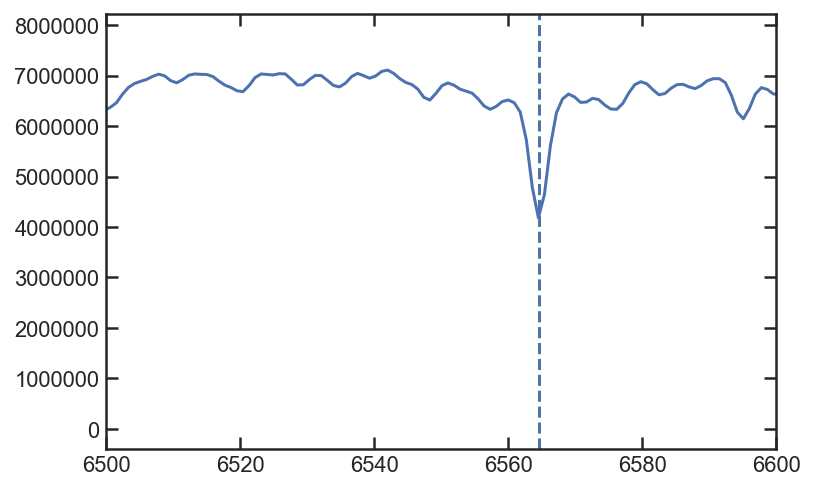

In [292]:
plt.plot(wave2,flux2)
plt.xlim(6500, 6600)
plt.axvline(4102.89 ,linestyle='--', color = 'b')
plt.axvline(4341.68 ,linestyle='--', color = 'b')
plt.axvline(4862.68 ,linestyle='--', color = 'b')
plt.axvline(6564.61,linestyle='--', color = 'b')

In [301]:
ls ../data/posteriors/*simtab*


../data/posteriors/GND_23459_simtabfit_Pa.npy
../data/posteriors/GND_23459_simtabfit_Pba.npy
../data/posteriors/GND_23459_simtabfit_Pbb.npy
../data/posteriors/GND_23459_simtabfit_Pbl.npy
../data/posteriors/GND_23459_simtabfit_Pbp1.npy
../data/posteriors/GND_23459_simtabfit_Pd.npy
../data/posteriors/GND_23459_simtabfit_Plm.npy
../data/posteriors/GND_23459_simtabfit_Pm.npy
../data/posteriors/GND_23459_simtabfit_Pm1.npy
../data/posteriors/GND_23459_simtabfit_Pm10.npy
../data/posteriors/GND_23459_simtabfit_Pm2.npy
../data/posteriors/GND_23459_simtabfit_Pm3.npy
../data/posteriors/GND_23459_simtabfit_Pm4.npy
../data/posteriors/GND_23459_simtabfit_Pm5.npy
../data/posteriors/GND_23459_simtabfit_Pm6.npy
../data/posteriors/GND_23459_simtabfit_Pm7.npy
../data/posteriors/GND_23459_simtabfit_Pm8.npy
../data/posteriors/GND_23459_simtabfit_Pm9.npy
../data/posteriors/GND_23459_simtabfit_Pra.npy
../data/posteriors/GND_23459_simtabfit_Prb.npy
../data/posteriors/GND_23459_simtabfit_Prl.npy
../data/poster

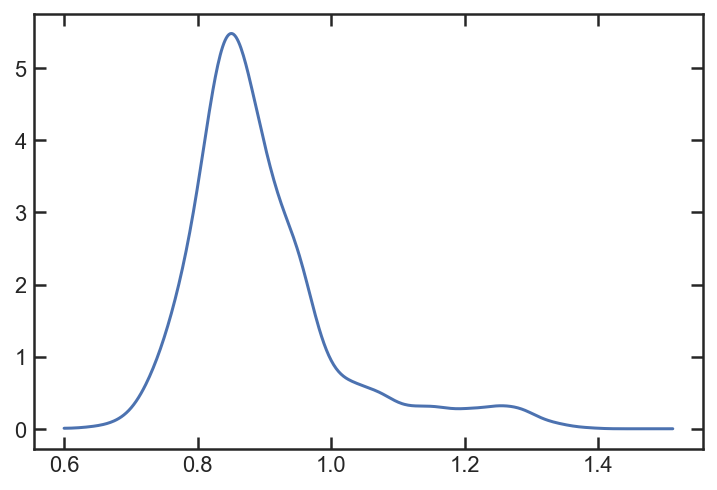

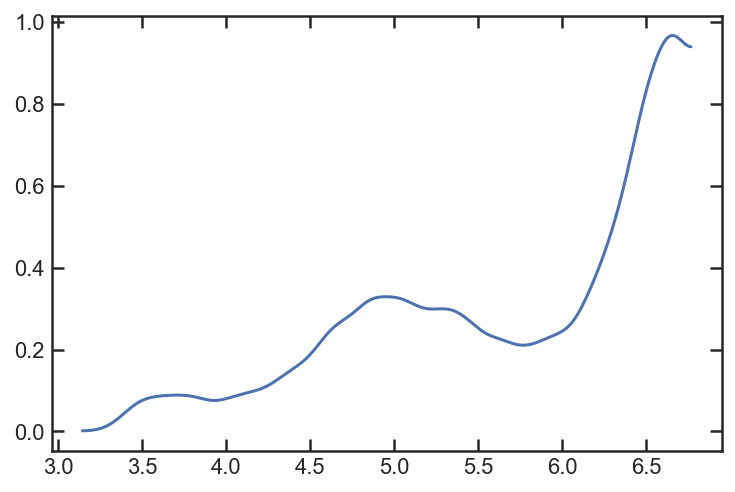

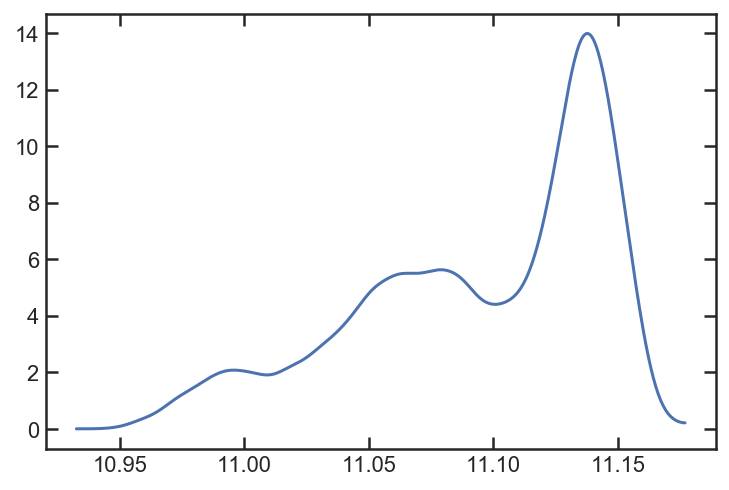

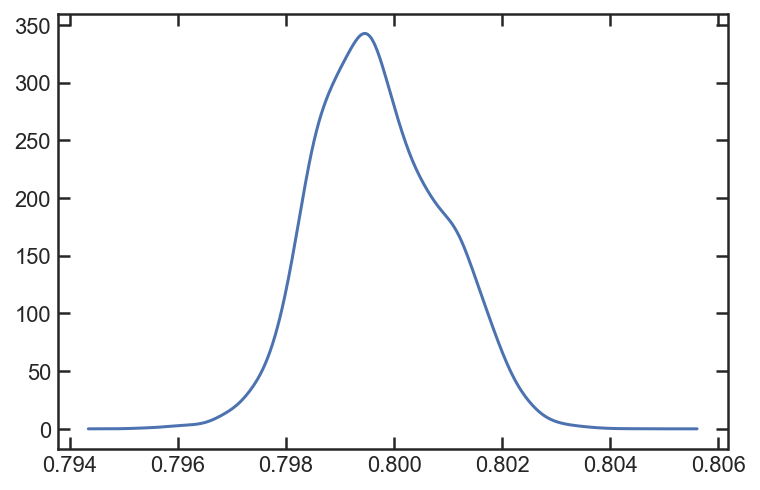

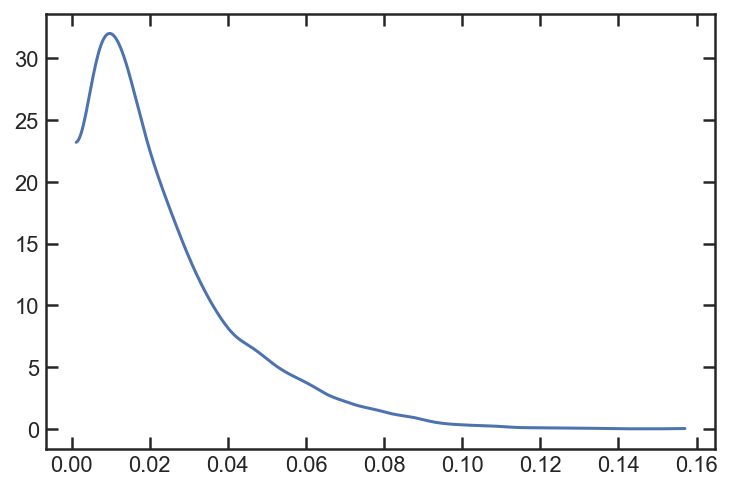

In [101]:
params = ['m', 'a', 'lm','z', 'd']
for i in range(len(params)):
    t,pt = np.load('../data/posteriors/GND_23459_simtabfit_P{}.npy'.format(params[i]))
    plt.figure()
    plt.plot(t,pt)

In [102]:
from spec_tools import Gen_PPF, Oldest_galaxy, convert_sfh, get_agebins, Derive_SFH_weights, boot_to_posterior, Highest_density_region
class Gen_SFH_sim(object):
    def __init__(self, field, galaxy, redshift, trials = 1000):

        ppf_dict = {}


        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']
        x,px = np.load('../data/posteriors/{}_{}_simtabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]


        for i in params:
            x,px = np.load('../data/posteriors/{}_{}_simtabfit_P{}.npy'.format(field, galaxy,i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0

        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []
        mwa_grid = []
        
        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                masses = draw[1:len(params) - 1]
                lmass = draw[-1]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0], binnum=len(params) - 2), masses, maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**lmass / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**lmass)

                mwa_grid.append(np.trapz(sfr_grid[idx]*self.fulltimes,self.fulltimes)/np.trapz(sfr_grid[idx],self.fulltimes))
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### mwa values
        x,y = boot_to_posterior(mwa_grid[0:trials], weights)
        self.mwa, self.mwa_hci, self.mwa_offreg = Highest_density_region(y,x)
    
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                              
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid
        self.t_80_grid = t_80_grid
        self.t_90_grid = t_90_grid
        self.mwa_grid = mwa_grid

In [103]:
SFH = Gen_SFH_sim('GND',23459,0.8)

In [104]:
SFH.z_50

7.342197747753071

In [105]:
lbt, sfh = np.load('../data/SFH/sim_sfh.npy')


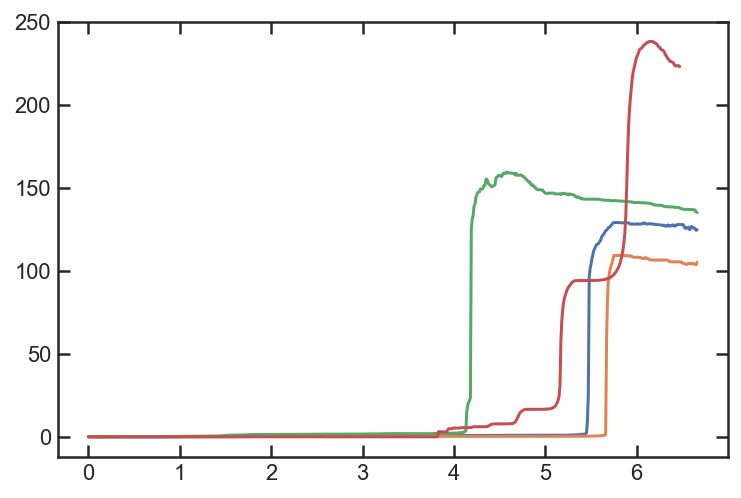

In [106]:
plt.plot(SFH.LBT, SFH.SFH)
plt.plot(SFH.LBT, SFH.SFH_16)
plt.plot(SFH.LBT, SFH.SFH_84)

plt.plot(lbt, sfh)

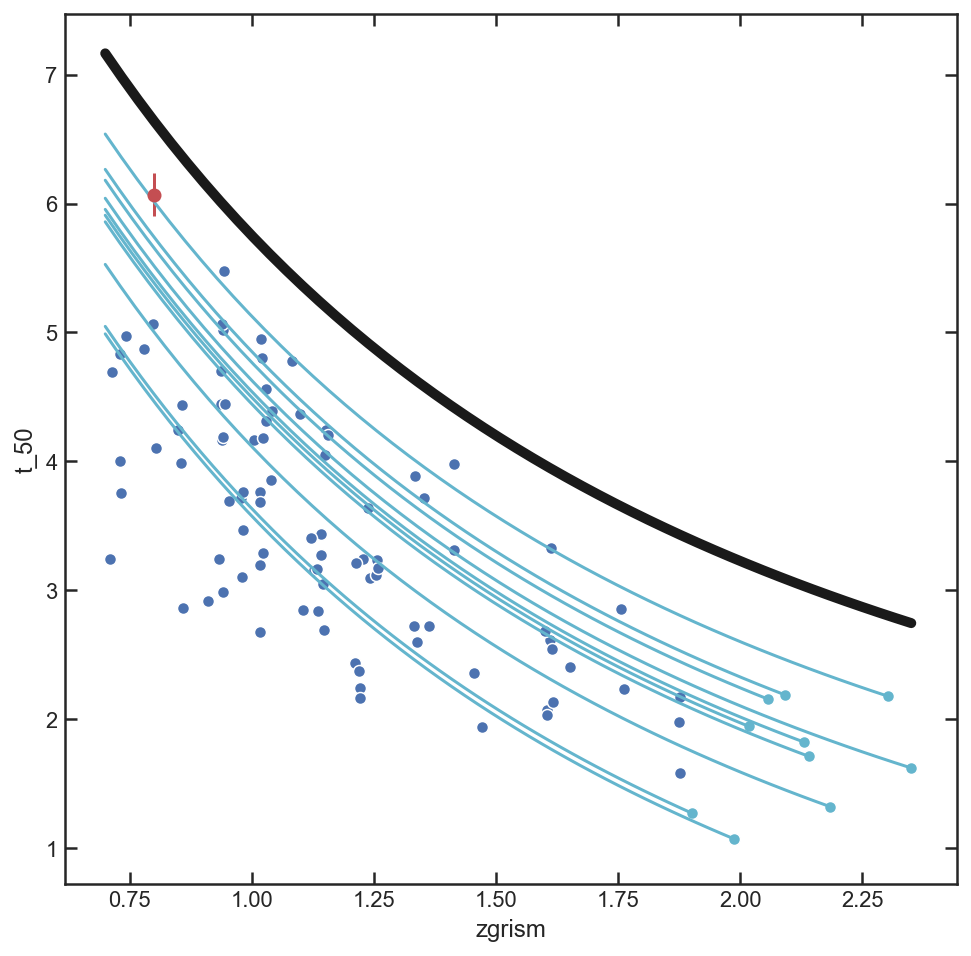

In [117]:
plt.figure(figsize =[8,8])
sea.scatterplot(mdb.zgrism,mdb.t_50)
plt.errorbar(0.8, SFH.t_50, yerr=[[SFH.t_50 - 5.9], [6.24 - SFH.t_50]], fmt='ro')

for i in S1db.index[-10:]:  
    z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
    a_init = cosmo.age(z_init).value
    zs = np.linspace(0.7, z_init)
    a = cosmo.age(zs).value
    a -= a_init
    sea.scatterplot(mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism, 
                    mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50, color = 'c')
    plt.plot(zs, mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a, color = 'c')
plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

In [108]:
SFH.t_50_hci

[5.907270426543935, 6.245922443030963]

In [110]:
from spec_id import Gather_simgrism_data
galaxy = 23459
field = 'GND'
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)


#########load in model spectra########
lbt, sfh = np.load('../data/SFH/sim_sfh.npy')
sp.set_tabular_sfh(lbt,sfh[::-1]/np.trapz(sfh, lbt*1E9)) 
wave, flux = sp.get_spectrum(tage = 6.008, peraa = True)

###########gen spec##########
Gs = Gen_spec(field, galaxy, 1, phot_errterm = 0.04, irac_err = 0.08) 
flam = F_lam_per_M(flux,wave*(1+0.8),0.8,0,sp.stellar_mass)*10**11

Gs.Make_sim(wave,flam,specz=0.8, rndstate=100)
    
wvs, flxs, errs, beams, trans = Gather_simgrism_data(Gs)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat26dtq_flt.fits G102
2 icat26dyq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt61gvq_flt.fits G102
14 icxt61gwq_flt.fits G102
15 icxt61gzq_flt.fits G102
16 icxt61h1q_flt.fits G102
17 icxt64qrq_flt.fits G102
18 icxt64qsq_flt.fits G102
19 icxt64qvq_flt.fits G102
20 icxt64qxq_flt.fits G102
21 icxt65evq_flt.fits G102
22 icxt65ewq_flt.fits G102
23 icxt65ezq_flt.fits G102
24 icxt65f1q_flt.fits G102
25 ib3726bpq_flt.fits G141
26 ib3726btq_flt.fits G141
27 ib3726c5q_flt.fits G141
28 ib3726c9q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icat26dtq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2 icat26dyq_flt.fits G102
3 icat26e5q_flt.fits G102
4 icat26eaq_flt.fits G102
5 icxt62lkq_flt.fits G102
6 icxt62llq_flt.fits G102
7 icxt62loq_flt.fits G102
8 icxt62lqq_flt.fits G102
9 icxt63ltq_flt.fits G102
10 icxt63luq_flt.fits G102
11 icxt63lxq_flt.fits G102
12 icxt63lzq_flt.fits G102
13 icxt61gvq_flt.fits G102
14 icxt61gwq_flt.fits G102
15 icxt61gzq_flt.fits G102
16 icxt61h1q_flt.fits G102
17 icxt64qrq_flt.fits G102
18 icxt64qsq_flt.fits G102
19 icxt64qvq_flt.fits G102
20 icxt64qxq_flt.fits G102
21 icxt65evq_flt.fits G102
22 icxt65ewq_flt.fits G102
23 icxt65ezq_flt.fits G102
24 icxt65f1q_flt.fits G102
25 ib3726bpq_flt.fits G141
26 ib3726btq_flt.fits G141
27 ib3726c5q_flt.fits G141
28 ib3726c9q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

In [111]:
m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl\
, bflogz= np.load('../data/posteriors/{0}_{1}_simtabfit_bfit.npy'.format(field, galaxy))

In [112]:
from spec_id import Full_forward_model, F_lam_per_M, Full_calibrate_2

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr ) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**11, z, 
                                wvs, flxs, errs, beams, trans)

Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], wvs, flxs, errs)

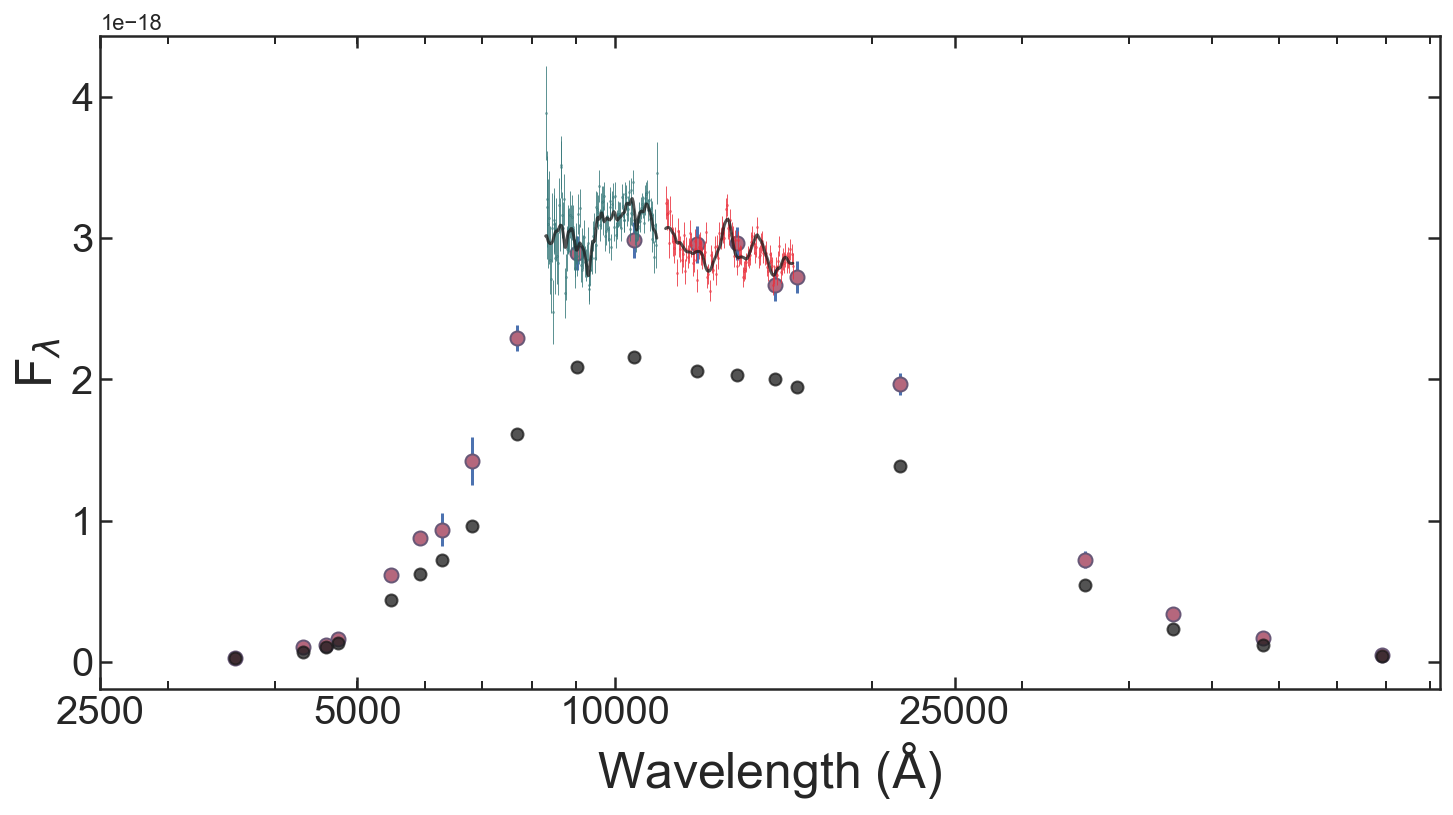

In [113]:
#     Flam = Posterior_spec(field[i], galaxies[i])

#     x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
#     bp1 = x[px == max(px)][0]
#     x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
#     rp1 = x[px == max(px)][0]

#     Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

#     sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

plt.figure(figsize =[12,6])
ax2 = plt.subplot()
ax2.errorbar(wvs[0], flxs[0], errs[0],
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
ax2.plot(wvs[0], Gmfl[0],'k', zorder = 4, alpha = 0.75)


ax2.errorbar(wvs[1], flxs[1], errs[1],
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
ax2.plot(wvs[1], Gmfl[1],'k', zorder = 4, alpha = 0.75)



ax2.errorbar(Gs.Pwv,Gs.SPflx,Gs.SPerr,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)
ax2.plot(Gs.Pwv, Pmfl,'ko', zorder = 4, alpha = 0.75)

ax2.set_xscale('log')

ax2.set_xticks([2500,5000,10000,25000])
ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
# ax2.legend(fontsize=15, frameon = True, loc = 1)
ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

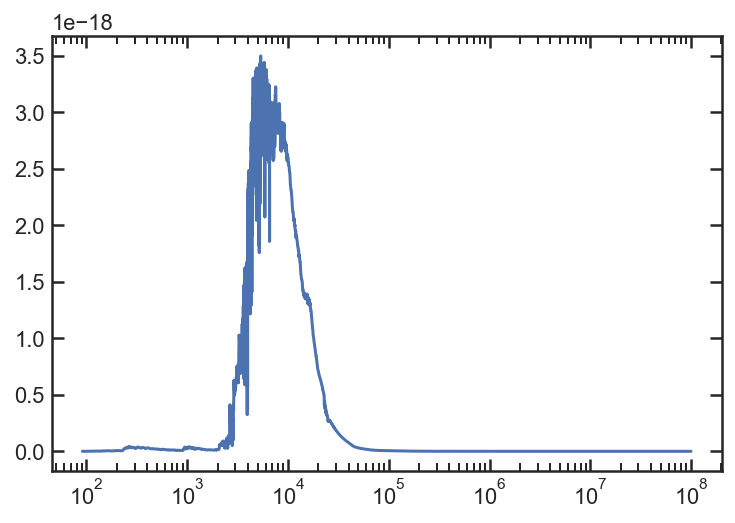

In [95]:
plt.plot(wave,flam)
plt.xscale('log')

0.9997301796728776
1.0


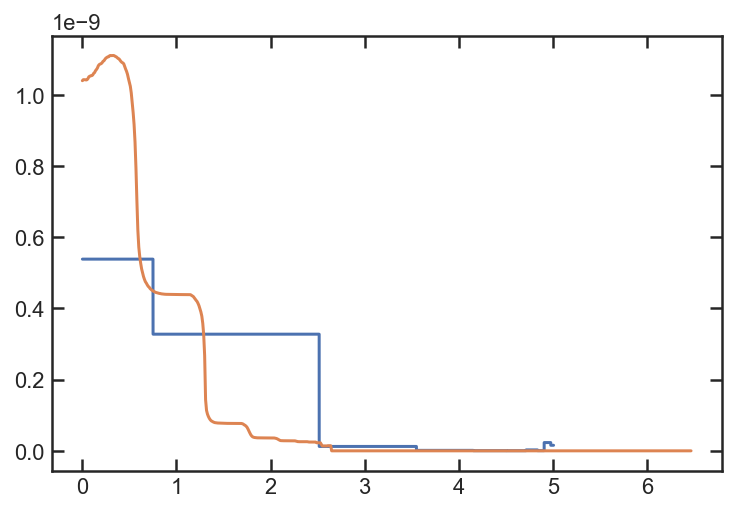

In [92]:
plt.plot(time,sfr)
plt.plot(lbt, sfh[::-1]/ np.trapz(sfh, lbt*1E9))
print(np.trapz(sfr, time*1E9))
print(np.trapz(sfh/np.trapz(sfh, lbt*1E9), lbt*1E9))

# Getting probability

In [212]:
zx_range = np.linspace(mdb.zgrism.values.min(), mdb.zgrism.values.max(), 1000)

smooth_grid = []

for i in range(1000):
    IDX = np.random.choice(mdb.query('zgrism > 0.9').index.values,len(mdb.query('zgrism > 0.9').index))
    
    regsDF, evalDF = LOWESS(mdb.zgrism[IDX].values,mdb.t_50[IDX].values, alpha = 0.6)

    l_x  = evalDF['v'].values
    l_y  = evalDF['g'].values
    
    
    smooth_grid.append(interp1d(l_x, l_y, bounds_error=False, fill_value=0)(zx_range))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [214]:
smooth_grid

array([[0.        , 0.        , 0.        , ..., 1.56902649, 1.56739851,
        1.56577053],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.3116837 , 1.3093838 ,
        1.30708391],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.52687451, 1.52431617,
        1.52175783]])

In [216]:
smooth_grid = np.array(smooth_grid)

Sm = []
Sh = []
Sl = []
nz = []

for i in range(len(zx_range)):
    Tarray = smooth_grid.T[i]
    
    if len(Tarray[Tarray > 0]):
        Sm.append(np.percentile(Tarray[Tarray > 0], 50))
        Sh.append(np.percentile(Tarray[Tarray > 0], 84))
        Sl.append(np.percentile(Tarray[Tarray > 0], 16))
        nz.append(zx_range[i])
        

In [217]:
np.save('../data/plot_points/hzgal_z_t50_lowess', [nz, Sm, Sl, Sh])

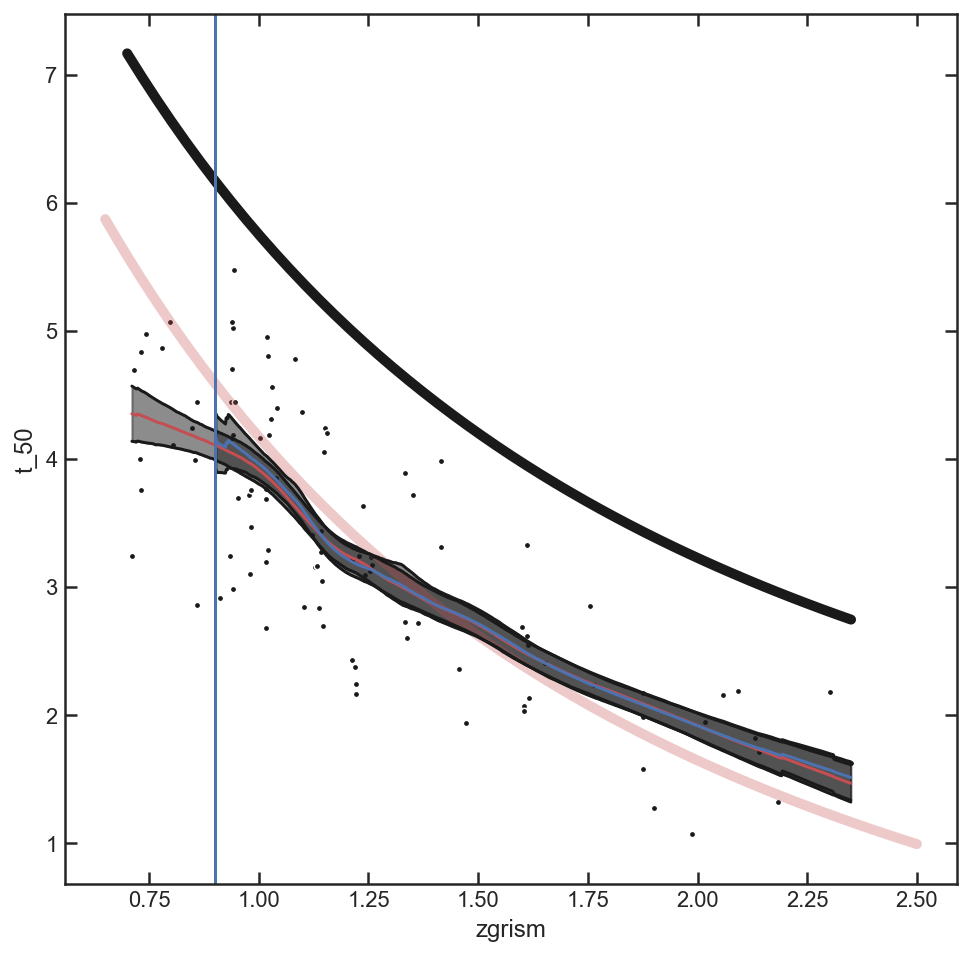

In [224]:
plt.figure(figsize =[8,8])
sea.scatterplot(mdb.zgrism,mdb.t_50, color = 'k', s = 10)

i = S1db.query('t_50 == {}'.format(max(S1db.query('zgrism < 0.9').t_50))).index.values[0]
z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
a_init = cosmo.age(z_init).value
zs1 = np.linspace(z_init, 2.5)
a1 = cosmo.age(zs1).value
a1 -= a_init

a_init = cosmo.age(z_init).value
zs2 = np.linspace(0.65, z_init)
a2 = cosmo.age(zs2).value
a2 -= a_init


plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

rshift = np.append(zs2[:-1], zs1)

tlim = np.append((mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a2)[:-1], 
          mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a1)

itlim = interp1d(rshift, tlim)
plt.plot(rshift, itlim(rshift), 'r', linewidth = 5, alpha = 0.3)


za, Sam, Sal, Sah = np.load('../data/plot_points/allgal_z_t50_lowess.npy')
zl, Slm, Sll, Slh = np.load('../data/plot_points/hzgal_z_t50_lowess.npy')

plt.plot(za, Sam, 'r')
plt.plot(za, Sah, 'k')
plt.plot(za, Sal, 'k')
plt.fill_between(za, Sal, Sah, alpha = 0.5, color = 'k')

plt.plot(zl, Slm, 'b')
plt.plot(zl, Slh, 'k')
plt.plot(zl, Sll, 'k')
plt.fill_between(zl, Sll, Slh, alpha = 0.5, color = 'k')
plt.axvline(0.9)

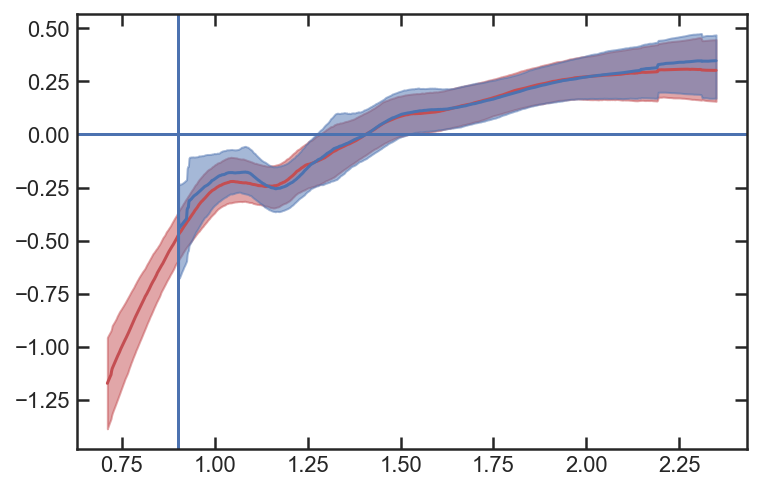

In [223]:
plt.plot(za, Sam- itlim(za), 'r')
plt.fill_between(za, Sal- itlim(za), Sah- itlim(za), alpha = 0.5, color = 'r')

plt.plot(zl, Slm- itlim(zl), 'b')
plt.fill_between(zl, Sll- itlim(zl), Slh- itlim(zl), alpha = 0.5, color = 'b')

plt.axhline()
plt.axvline(0.9)